In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

## Data Exploration and Simple Clustering.

README file shows that for each record in the dataset, it is provided triaxial acceleration, triaxial angular velocity, a 561-feature vector, activity label, and experiment subject identifier.

For the purpose of simplicity and avoiding going deeper in engineer feature, we focus only in acceleration and velocity infomation, and treat every subject as the same (meaning subject identifier is not included in dataset).

In [2]:
#Read the df_body_acc_x_train.txt file.
path = "UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt"
df_body_acc_x = pd.read_csv(path, header=None, delim_whitespace=True)
df_body_acc_x

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.388873,0.618763,0.774067,0.586568,0.217007,-0.027330,-0.171294,-0.218988,-0.137680,0.033094,...,-0.227949,-0.247119,-0.227710,-0.210942,-0.179295,-0.142085,-0.131831,-0.154000,-0.176886,-0.211068
7348,0.711864,0.709237,0.321368,-0.028921,-0.208107,-0.192802,-0.066754,-0.042285,0.058089,0.106855,...,-0.311864,-0.316281,-0.274100,-0.326159,-0.379539,-0.382544,-0.371156,-0.295357,-0.203831,-0.124548
7349,-0.226717,-0.177817,-0.150869,-0.132237,-0.068338,0.007874,0.096481,0.205834,0.441342,0.662930,...,-0.177051,-0.248426,-0.313892,-0.367070,-0.395135,-0.347338,-0.319902,-0.294935,-0.243403,-0.215215
7350,-0.064806,-0.079933,-0.068350,-0.038477,-0.028679,0.018335,0.077571,0.253580,0.507805,0.583999,...,-0.240819,-0.330930,-0.396854,-0.413906,-0.379085,-0.356609,-0.317618,-0.315016,-0.330737,-0.272348


Shape of body_acc_x_train.txt file is (7352, 128) and other files have the same shape. 

In [3]:
df_body_acc_x.shape

(7352, 128)

Load and check the proportion of each label. There is no significant imbalance among labels, so we may not have to rebalance the data.

In [4]:
y_train = pd.read_csv("UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None, delim_whitespace=True)
y_train.value_counts(sort=False, normalize=True)

1    0.166757
2    0.145947
3    0.134113
4    0.174918
5    0.186888
6    0.191376
dtype: float64

Before we perform a simple clustering, we need to process data because the raw data was segmented into small sequences, each has 128 timesteps with the overlap rate is 50%. The mid-point is at index 64. It means that the half-right part of a row is equal to the half-left part of the next row.

Check if the half-right part of the first row is the same with the half-left of the second row.

In [5]:
df_body_acc_x.iloc[1,:64].values == df_body_acc_x.iloc[0,64:].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

We can drop the half-right of the whole dataset then stretch the rows and combine them into one continuous timeline.

In [6]:
#Drop half-right the whole dataset.
df_body_acc_x = df_body_acc_x.iloc[:,:64]

body_acc_x = pd.Series(dtype='float')
#Stretch out the rows and combine them into one Series.
for i in range(len(df_body_acc_x)):
    body_acc_x = body_acc_x.append(df_body_acc_x.iloc[i])

Process similarly to body_acc_y.txt and body_acc_z.txt files.

In [7]:
path = "UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt"
df_body_acc_y = pd.read_csv(path, header=None, delim_whitespace=True)
df_body_acc_y = df_body_acc_y.iloc[:,:64]

body_acc_y = pd.Series(dtype='float')
for i in range(len(df_body_acc_y)):
    body_acc_y = body_acc_y.append(df_body_acc_y.iloc[i])

In [8]:
path = "UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt"
df_body_acc_z = pd.read_csv(path, header=None, delim_whitespace=True)
df_body_acc_z = df_body_acc_z.iloc[:,:64]

body_acc_z = pd.Series(dtype='float')
for i in range(len(df_body_acc_z)):
    body_acc_z = body_acc_z.append(df_body_acc_z.iloc[i])

In [9]:
print("Length of body_acc_x:", len(body_acc_x))
print("Length of body_acc_y:", len(body_acc_y))
print("Length of body_acc_z:", len(body_acc_z))

Length of body_acc_x: 470528
Length of body_acc_y: 470528
Length of body_acc_z: 470528


Each activity type is labeled to the whole 128-timesteps sequence. Now we stretch sequences along one timeline, we need to label for each timestep in the sequence, not the sequence itself.

In [10]:
activity_label = pd.Series(dtype='int')

for i in range(len(df_body_acc_x)):
    label_seq = pd.Series([int(y_train.iloc[i])]*64)
    activity_label = activity_label.append(label_seq)

In [11]:
print("Length of activity_label:", len(activity_label))

Length of activity_label: 470528


All Series of body accelerometers and activity labels have the same length. We can combine all of them into one dataframe.

In [12]:
body_acc = pd.DataFrame()
body_acc = pd.concat([activity_label, body_acc_x, body_acc_y, body_acc_z], axis=1)
body_acc.columns = ['activity_label', 'body_acc_x', 'body_acc_y', 'body_acc_z']
body_acc

,activity_label,body_acc_x,body_acc_y,body_acc_z
0,5,0.000181,0.010767,0.055561
1,5,0.010139,0.006579,0.055125
2,5,0.009276,0.008929,0.048405
3,5,0.005066,0.007489,0.049775
4,5,0.010810,0.006141,0.043013
...,...,...,...,...
59,2,-0.356609,0.058079,0.093735
60,2,-0.317618,0.062533,0.143814
61,2,-0.315016,0.054517,0.165826
62,2,-0.330737,0.014367,0.210957


We scatter plot 3 pairs of axes (x-axis vs y-axis; x-axis vs z-axis; y-axis vs z-axis). The six clusters of six activities (walking, walking upstairs, walking downstairs, sitting, standing, laying) are not clearly seperated but we can see they are formed in certain areas. This could be easier detected by a deep learning model rather than by visualization. We will build a deep learning model to classify activities in the next part.

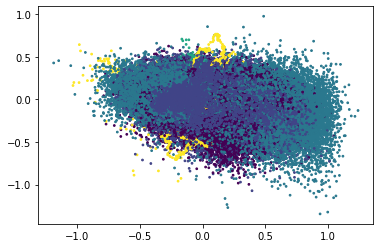

In [13]:
plt.scatter(body_acc['body_acc_x'], body_acc['body_acc_y'], s=3, c=body_acc['activity_label'])

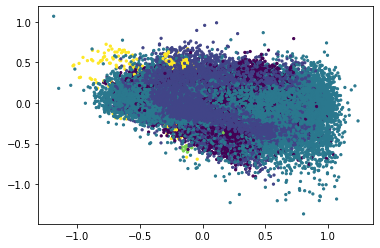

In [14]:
plt.scatter(body_acc['body_acc_x'], body_acc['body_acc_z'], s=5, c=body_acc['activity_label'])

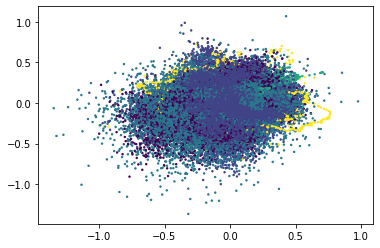

In [15]:
plt.scatter(body_acc['body_acc_y'], body_acc['body_acc_z'], s=2, c=body_acc['activity_label'])

## Classification Model.

In [16]:
train_main_path = "UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals/"

train_inertial_signal_files = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt',
                         'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                         'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

This is a time series dataset so the ideal input shape is in 3-dimension stucture (no of samples, no of timesteps, no of features). Each dataset in Inertial Signals folder has structure (no of samples, 128-timesteps). We will use numpy.dstack() function to stack all the datasets into one dataset to creat the 3rd dimenstion (..., no of features).

In [17]:
train_dataset = []

for file in train_inertial_signal_files:
    dataset = pd.read_csv(train_main_path + file, header=None, delim_whitespace=True)
    dataset = dataset.values
    train_dataset.append(dataset)
    
train_dataset = np.dstack(train_dataset)

We process the test dataset similarly.

In [18]:
test_main_path = "UCI HAR Dataset/UCI HAR Dataset/test/Inertial Signals/"

test_inertial_signal_files = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt',
                         'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                         'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

In [19]:
test_dataset = []

for file in test_inertial_signal_files:
    dataset = pd.read_csv(test_main_path + file, header=None, delim_whitespace=True)
    dataset = dataset.values
    test_dataset.append(dataset)
    
test_dataset = np.dstack(test_dataset)

The LSTM layer in Keras requires the Label set has the same shape with its output, so we will transform Label set from (no of samples, 1) to (no of samples, no of labels). Pandas.get_dummy() functions can help us to transform it to dummy/one-hot-encoding matrix.

In [20]:
train_label = pd.read_csv("UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header=None, delim_whitespace=True)
train_label = train_label.astype(str)
train_label = np.asarray(pd.get_dummies(train_label), dtype = np.float32)

In [21]:
test_label = pd.read_csv("UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header=None, delim_whitespace=True)
test_label = test_label.astype(str)
test_label = np.asarray(pd.get_dummies(test_label), dtype = np.float32)

Now the shape of input train and label dataset are compatible with LSTM layer's input.

In [22]:
print("Dimenstion of Train dataset:", train_dataset.shape)
print("Dimenstion of Train label:", train_label.shape)
print("Dimenstion of Test dataset:", test_dataset.shape)
print("Dimenstion of Test label:", test_label.shape)

Dimenstion of Train dataset: (7352, 128, 9)
Dimenstion of Train label: (7352, 6)
Dimenstion of Test dataset: (2947, 128, 9)
Dimenstion of Test label: (2947, 6)


In [23]:
model = Sequential()
model.add(LSTM(units = 128))
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(6, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model.fit(train_dataset, train_label, epochs = 10, validation_split = 0.20)

Epoch 1/10
184/184 [==============================] - 10s 46ms/step - loss: 1.1198 - accuracy: 0.5302 - val_loss: 0.9762 - val_accuracy: 0.5887
Epoch 2/10
184/184 [==============================] - 8s 44ms/step - loss: 0.7802 - accuracy: 0.6650 - val_loss: 1.0787 - val_accuracy: 0.6587
Epoch 3/10
184/184 [==============================] - 8s 44ms/step - loss: 0.7951 - accuracy: 0.6820 - val_loss: 0.9647 - val_accuracy: 0.6907
Epoch 4/10
184/184 [==============================] - 8s 44ms/step - loss: 0.5170 - accuracy: 0.8123 - val_loss: 0.6451 - val_accuracy: 0.8232
Epoch 5/10
184/184 [==============================] - 8s 44ms/step - loss: 0.3809 - accuracy: 0.8716 - val_loss: 0.5884 - val_accuracy: 0.8722
Epoch 6/10
184/184 [==============================] - 8s 44ms/step - loss: 0.2446 - accuracy: 0.9129 - val_loss: 0.6328 - val_accuracy: 0.8443
Epoch 7/10
184/184 [==============================] - 8s 44ms/step - loss: 0.1902 - accuracy: 0.9379 - val_loss: 0.4771 - val_accuracy: 0.890

In [25]:
loss, accuracy = model.evaluate(test_dataset, test_label)
print("Loss of the model:", round(loss, 2))
print("Accuracy of the model:", round(accuracy, 2))

93/93 [==============================] - 1s 15ms/step - loss: 0.4997 - accuracy: 0.8924
Loss of the model: 0.5
Accuracy of the model: 0.89


The Accuracy is around 90%. It's a good classification rate and this matches with our comment in the former part. The clusters of six activities may not be clear enough to be visualized but they are formed in certain areas when plotting; it could be easier to classify by a deep learning model.